In [1]:
import os
# fixes a bug with inv/pinv/null_space on GPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false" 
import jax
import jax.numpy as jnp
import numpy as onp
import immrax as irx
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pypoman import compute_polytope_vertices, plot_polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})

# Figure 1

[-1.  1.  1. -1.] >/=_SE 0
[ 1.  2. -1. -2.] >=_SE 0
[-1.4901161e-07  1.0000005e+00  1.3333331e+00  1.4901161e-07
 -1.0000005e+00 -1.3333331e+00] >=_SE 0


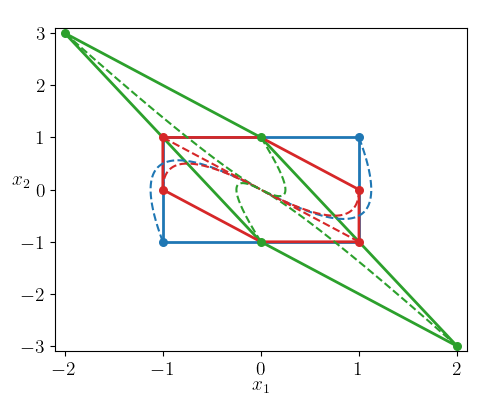

In [2]:
%matplotlib widget

# If this script fails to run due to some GPU issues on inv, pinv, or null_space, 
# try setting XLA_PYTHON_CLIENT_PREALLOCATE=false before running the script.

fig, ax1 = plt.subplots(1,1,figsize=(5,4)) 
fig.tight_layout()
ax1.set_xlim(-2.1, 2.1)
ax1.set_ylim(-3.1, 3.1)
ax1.set_xlabel(r'$x_1$', labelpad=-2)
ax1.set_ylabel(r'$x_2$', labelpad=0, rotation=0)

class DoubleIntegrator (irx.ControlledSystem) :
    def __init__(self) :
        self.evolution = 'continuous'
        self.xlen = 2
    def f(self, t, x, u, w) :
        return jnp.array([x[1], u[0]])

sys = DoubleIntegrator()

K = jnp.array([[-2., -3.]])
control = irx.LinearControl(K)

x0 = irx.icentpert(jnp.zeros(2), 1.)

# In standard coordinates, [-1,1]\times[-1,1] is not FI.
clsys = irx.ControlledSystem(sys, control)
embsys = irx.jacemb(clsys)
izero = irx.interval([0.])
print(f'{embsys.E(izero, irx.i2ut(x0), izero)} >/=_SE 0')
ax1.add_patch(Rectangle((-1.,-1.), 2., 2., fill=False, edgecolor='tab:blue', linewidth=2.))

# In transformed coordinates, [-1,1]\times[-1,1] is FI.
T = jnp.array([[1., 1.], [-1., -2.]])
Tinv = jnp.linalg.inv(T) 
lifted_clsys = irx.LiftedSystem(clsys, Tinv, T)
lifted_embsys = irx.jacemb(lifted_clsys)
print(f'{lifted_embsys.E(izero, irx.i2ut(x0), izero)} >=_SE 0')
plot_polygon(compute_polytope_vertices(
    onp.vstack((-Tinv, Tinv)), onp.concatenate((-x0.lower, x0.upper))),
    alpha=1., fill=False, color='tab:green', linewidth=2.)

# We can also verify another polytope using different lifted coordinates.
H = jnp.array([[1., 0.], [0., 1.], [1., 1.]])
Hp = jnp.linalg.pinv(H)
lifted_clsys = irx.LiftedSystem(clsys, H, Hp)
lifted_embsys = irx.jacemb(lifted_clsys)
N = irx.utils.null_space(H.T)
I_H = irx.utils.I_refine(N.T)
y0 = irx.icentpert(jnp.zeros(3), 1.)
print(f'{lifted_embsys.E(izero, irx.i2ut(y0), izero, refine=I_H)} >=_SE 0')
plot_polygon(compute_polytope_vertices(
    onp.vstack((-H, H)), onp.concatenate((-y0.lower, y0.upper))),
    alpha=1., fill=False, color='tab:red', linewidth=2.)

# Plotting some simulations.
x0s = jnp.array([
    [-2., 3.], [2., -3.],
    [1.,1.], [-1.,-1.],
    [1.,-1.], [-1.,1.],
    [-1.,0.], [1.,0.],
    [0.,1.], [0.,-1.],
])
colors = [
    'tab:green', 'tab:green',
    'tab:blue', 'tab:blue',
    'tab:red', 'tab:red',
    'tab:red', 'tab:red',
    'tab:green', 'tab:green',
]

def w_map (t, x) :
    return jnp.array([0.])
for i, x0 in enumerate(x0s) :
    traj = clsys.compute_trajectory(0., 5., x0, (w_map,), 0.01, solver='tsit5')
    tfinite = jnp.isfinite(traj.ts)
    xx = traj.ys[tfinite]
    ax1.plot(xx[:,0], xx[:,1], color=colors[i], linestyle='--')
    ax1.scatter(xx[0,0], xx[0,1], s=30., color=colors[i])

fig.savefig('figure1.pdf')
fig.savefig('figure1.svg')


# Figure 2

In [3]:
_y, y_ = irx.i2lu(y0)

_Y = irx.interval(jnp.tile(_y, (3,1)), jnp.where(jnp.eye(3), _y, jnp.tile(y_, (3,1))))
_Yref = jax.vmap(I_H)(_Y)

Y_ = irx.interval(jnp.where(jnp.eye(3), y_, jnp.tile(_y, (3,1))), jnp.tile(y_, (3,1)))
Y_ref = jax.vmap(I_H)(Y_)

print(_Yref)
print(Y_ref)


[[[(-1.00000000e+00, -1.00000000e+00)]
  [(-0.00000000e+00,  1.00000000e+00)]
  [(-1.00000000e+00,  1.03238278e-07)]]

 [[( 1.03238278e-07,  1.00000000e+00)]
  [(-1.00000000e+00, -1.00000000e+00)]
  [(-1.00000000e+00, -1.03238278e-07)]]

 [[(-1.00000000e+00,  1.03238278e-07)]
  [(-1.00000000e+00, -0.00000000e+00)]
  [(-1.00000000e+00, -1.00000000e+00)]]]
[[[( 1.00000000e+00,  1.00000000e+00)]
  [(-1.00000000e+00, -0.00000000e+00)]
  [(-1.03238278e-07,  1.00000000e+00)]]

 [[(-1.00000000e+00, -1.03238278e-07)]
  [( 1.00000000e+00,  1.00000000e+00)]
  [( 1.03238278e-07,  1.00000000e+00)]]

 [[(-1.03238278e-07,  1.00000000e+00)]
  [(-0.00000000e+00,  1.00000000e+00)]
  [( 1.00000000e+00,  1.00000000e+00)]]]


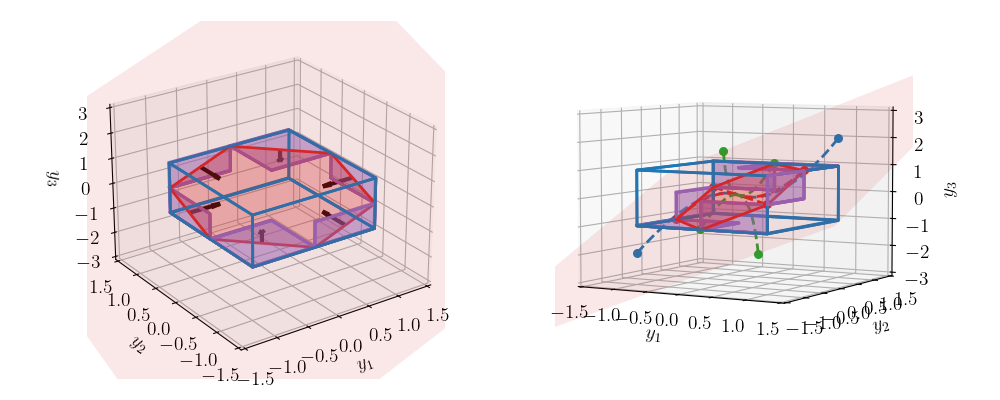

In [4]:
%matplotlib widget

# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d', figsize=(10,4))
fig, (ax2, ax1) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,4))
ax1.set_xlabel('$y_1$')
ax1.set_ylabel('$y_2$')
ax1.set_zlabel('$y_3$')
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_zlabel('$y_3$')
xylim = irx.icentpert(jnp.zeros(2), 1.5)

# Plot the box
irx.utils.draw_iarray_3d(ax1, y0, color='tab:blue', lw=2, poly_alpha=0.)
irx.utils.draw_iarray_3d(ax2, y0, color='tab:blue', lw=2, poly_alpha=0.)

# Plot the hyperplane
Hx = lambda x : H@x
verts = jax.vmap(Hx)(irx.utils.get_corners(xylim*2))
ax1.add_collection3d(Poly3DCollection([verts[(0,1,3,2),]], ec='none', fc='tab:red', alpha=0.1))
ax2.add_collection3d(Poly3DCollection([verts[(0,1,3,2),]], ec='none', fc='tab:red', alpha=0.1))

# Plot the intersection of calH and iy
xs = [[-1, 0], [0, -1], [1, -1], [1, 0], [0, 1], [-1, 1]]
verts = jax.vmap(Hx)(jnp.array(xs, dtype=jnp.float32))
ax1.add_collection3d(Poly3DCollection([verts], color='tab:red', lw=2, alpha=0.3))
ax2.add_collection3d(Poly3DCollection([verts], color='tab:red', lw=2, alpha=0.3))

# Plot the refined faces
vf = onp.zeros((6,3)); vf[0,0] = 1.; vf[1,1] = 1.; vf[2,2] = 1.; vf[3,0] = -1.; vf[4,1] = -1.; vf[5,2] = -1.
for i in range (3) :
    irx.utils.draw_iarray_3d(ax1, _Yref[i], color='tab:purple', lw=2, poly_alpha=0.3)
    irx.utils.draw_iarray_3d(ax1, Y_ref[i], color='tab:purple', lw=2, poly_alpha=0.3)
    irx.utils.draw_iarray_3d(ax2, _Yref[i], color='tab:purple', lw=2, poly_alpha=0.3)
    irx.utils.draw_iarray_3d(ax2, Y_ref[i], color='tab:purple', lw=2, poly_alpha=0.3)
    ax2.quiver(*_Yref[i].center, *vf[i], color='black', lw=3, alpha=1., length=0.5)
    ax2.quiver(*Y_ref[i].center, *vf[i+3], color='black', lw=3, alpha=1., length=0.5)

# Plot the system trajectories
for i, x0 in enumerate(x0s) :
    traj = clsys.compute_trajectory(0., 5., x0, (w_map,), 0.01, solver='tsit5')
    tfinite = jnp.isfinite(traj.ts)
    xx = traj.ys[tfinite]
    yy = jax.vmap(Hx)(xx)
    ax1.plot(yy[:,0], yy[:,1], yy[:,2], color=colors[i], linestyle='--', lw=2)
    ax1.scatter(yy[0,0], yy[0,1], yy[0,2], s=30., color=colors[i])

limits = irx.natif(Hx)(xylim)
ax1.set_xlim(irx.i2lu(limits[0]))
ax1.set_ylim(irx.i2lu(limits[1]))
ax1.set_zlim(irx.i2lu(limits[2]))
ax2.set_xlim(irx.i2lu(limits[0]))
ax2.set_ylim(irx.i2lu(limits[1]))
ax2.set_zlim(irx.i2lu(limits[2]))
# ax1.view_init (10, -65)
# ax1.view_init (20, -60)
ax1.view_init (5, -60)
ax2.view_init (25, -125)

fig.tight_layout()
fig.savefig('figure2.pdf')
fig.savefig('figure2.svg')